## Load the data and ignore the warnings

In [49]:
import sys
import pandas as pd
import csv

# Increase CSV field size limit
csv.field_size_limit(sys.maxsize)
# Reload with safe options
df = pd.read_csv('phishing_email_dataset.csv', engine='python', on_bad_lines='skip')

In [50]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82078 entries, 0 to 82077
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Message        82078 non-null  object
 1   label          82078 non-null  int64 
 2   Clean_Message  82076 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.9+ MB


,Message,label,Clean_Message
0,garp 2001 convention invitation speak invitati...,0,garp 2001 convention invitation speak invitati...
1,fly macromedia xp pro sp 2 adobe photoshop ms ...,1,fly macromedia pro 2 adobe photoshop office 2 ...
2,mr kala kabila kkkabila2003yahoocom kalla kabi...,1,kala kabila kkkabila2003yahoocom kalla kabila ...
3,william sister bright_william2008yahoocom dear...,1,william sister brightwilliam2008yahoocom dear ...
4,son masturbates watching mom sister pussies he...,1,son masturbates watching mom sister pussies he...


In [51]:
df['label'].value_counts(dropna=False)

,count
label,
1,42845
0,39233


In [52]:
# Show labels that are not exactly 0 or 1
df[~df['label'].astype(str).isin(['0', '1'])]['label'].unique()

array([], dtype=int64)

In [53]:
# Add 'source' column for visualizations
df['source'] = df['label'].apply(lambda x: 'phish' if x == 1 else 'benign')
df['source'].value_counts()

,count
source,
phish,42845
benign,39233


In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

## Feature 1: 'has_html'

In [55]:
import re

def contains_html(text):
    if pd.isnull(text):
        return 0
    return 1 if re.search(r'<.*?>', text) else 0


df['has_html'] = df['Message'].apply(contains_html)
df['has_html'].value_counts()

,count
has_html,
0,82078


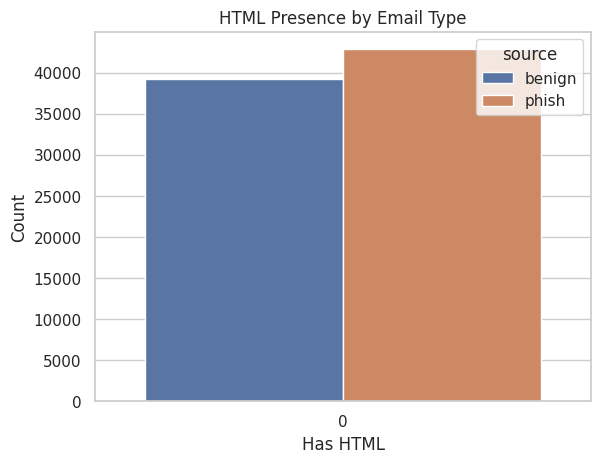

In [56]:
sns.countplot(x='has_html', hue='source', data=df)
plt.title("HTML Presence by Email Type")
plt.xlabel("Has HTML")
plt.ylabel("Count")
plt.show()

In [57]:
html_label_counts = df.groupby(['has_html', 'label']).size().unstack(fill_value=0)
html_label_counts.columns = ['Benign (label=0)', 'Phishing (label=1)']

if len(html_label_counts.index) == 2:
    html_label_counts.index = ['Without HTML (has_html=0)', 'With HTML (has_html=1)']
elif len(html_label_counts.index) == 1:
    only_val = html_label_counts.index[0]
    html_label_counts.index = [f'Only has_html={only_val} present']


In [58]:
print(html_label_counts)
print(html_label_counts.index)


                         Benign (label=0)  Phishing (label=1)
Only has_html=0 present             39233               42845
Index(['Only has_html=0 present'], dtype='object')


## Feature 2: link count

In [59]:
def count_links(text):
    if pd.isnull(text):
        return 0
    pattern = r'(https?://\S+|www\.\S+|\S+\.(com|net|org|info|edu|gov)(/\S*)?)'
    return len(re.findall(pattern, text))



df['link_count'] = df['Message'].apply(count_links)
df['link_count'].describe()


,link_count
count,82078.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


In [60]:
df.groupby('has_html')['link_count'].mean()

,link_count
has_html,
0,0.0


In [61]:
# # Filter out outliers for visualization clarity
# df_viz = df[df['link_count'] < 50]
# sns.boxplot(x='source', y='link_count', data=df_viz)

# plt.yscale('log')
# plt.title("Link Count Distribution (log scale)")
# plt.show()

## Feature 3: shannon_entropy

###  What is it?

**Shannon entropy** measures the **randomness** or **information density** in a text. It’s calculated based on the distribution of characters.

---

###  Why is it useful for phishing?

Phishing and spam messages often:

* Contain **obfuscated text** (random strings, gibberish)
* Hide malicious intent using **encoded text** (e.g., base64 or hex payloads)
* Have **higher entropy** than normal human-written messages

Benign messages, like regular reports or human emails, tend to have **lower entropy** (repetitive, structured).

---

###  How is it calculated?

The formula is:

$$
H = -\sum_{i} p_i \log_2 p_i
$$

Where:

* $p_i$ is the probability of character $i$
* We sum over all unique characters in the string



In [62]:
import math
from collections import Counter

def shannon_entropy(text):
    if pd.isnull(text) or not isinstance(text, str) or len(text) == 0:
        return 0
    counts = Counter(text)
    total = len(text)
    entropy = -sum((count/total) * math.log2(count/total) for count in counts.values())
    return entropy

df['entropy'] = df['Clean_Message'].apply(shannon_entropy)
# Check basic stats
df['entropy'].describe()


,entropy
count,82078.000000
mean,4.362905
std,0.167871
min,0.000000
25%,4.272461
50%,4.363283
75%,4.458017
max,5.153331


In [63]:
df.groupby('source')['entropy'].mean()

,entropy
source,
benign,4.356347
phish,4.368910


### Insight:
High entropy → more randomness → possibly phishing.


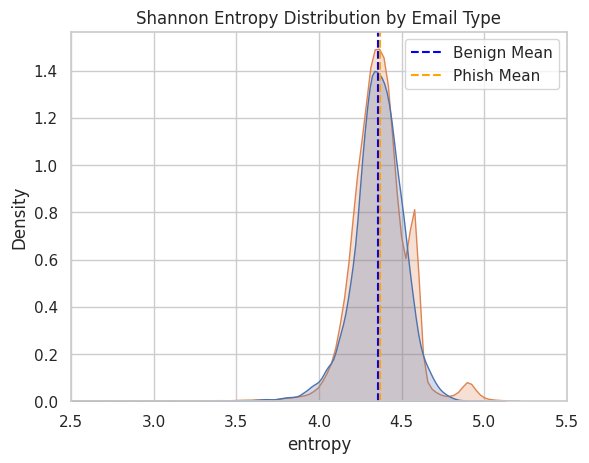

In [64]:
mean_values = df.groupby('source')['entropy'].mean()

sns.kdeplot(data=df, x='entropy', hue='source', fill=True)
plt.axvline(mean_values['benign'], color='blue', linestyle='--', label='Benign Mean')
plt.axvline(mean_values['phish'], color='orange', linestyle='--', label='Phish Mean')
plt.xlim(2.5, 5.5)
plt.title("Shannon Entropy Distribution by Email Type")
plt.legend()
plt.show()


### Insight:
Phishing emails exhibit slightly higher entropy than benign emails. This suggests that phishing messages tend to contain more randomized, obfuscated, or encoded content, which may help attackers evade detection.

## Feature 4: Urgency Keyword Score

In [65]:
# Strong urgency - usually associated with phishing
strong_urgency = [
    'urgent', 'immediately', 'action required', 'verify your account',
    'account suspended', 'update account', 'security alert',
    'confirm your identity', 'reset your password', 'limited time',
    'unauthorized access', 'unusual activity'
]

# Neutral urgency - commonly seen in benign alerts or notifications
neutral_urgency = [
    'click', 'login', 'update', 'respond', 'access',
    'alert', 'notice', 'information', 'submit',
    'deadline', 'due', 'reminder', 'verify'
]

# Weak/general verbs - may appear frequently but not always urgent
weak_urgency = [
    'now', 'here', 'available', 'check', 'follow',
    'help', 'support', 'assist', 'contact'
]


def compute_weighted_urgency_score(text):
    if pd.isnull(text) or not isinstance(text, str):
        return 0
    text = text.lower()

    score = 0
    # Count with weights
    score += sum(text.count(word) * 8 for word in strong_urgency)
    score += sum(text.count(word) * 2 for word in neutral_urgency)
    score += sum(text.count(word) * 0.5 for word in weak_urgency)

    return score

def contains_urgency_keywords(text):
    if pd.isnull(text) or not isinstance(text, str):
        return 0
    text = text.lower()
    all_keywords = strong_urgency + neutral_urgency + weak_urgency
    return int(any(word in text for word in all_keywords))



In [66]:
df['urgency_score'] = df['Clean_Message'].apply(compute_weighted_urgency_score)
df['has_urgency_keyword'] = df['Clean_Message'].apply(contains_urgency_keywords)

# Cap extreme urgency scores (to reduce impact of marketing templates)
upper_clip = df['urgency_score'].quantile(0.95)
df['urgency_score'] = df['urgency_score'].clip(upper=upper_clip)


In [67]:
df.groupby('source')['urgency_score'].mean()

,urgency_score
source,
benign,3.736689
phish,4.021753


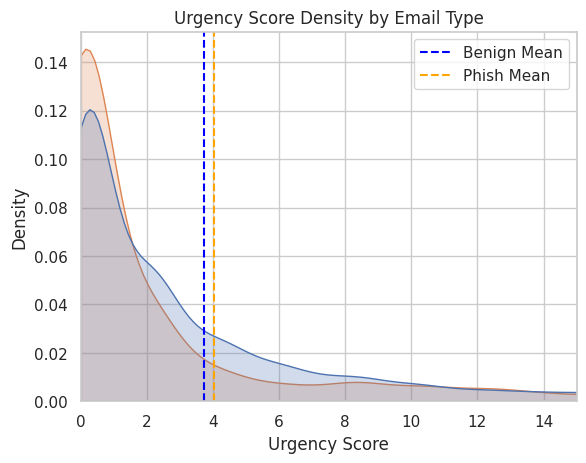

In [68]:
means = df.groupby('source')['urgency_score'].mean()

# Plot KDE with means
sns.kdeplot(data=df, x='urgency_score', hue='source', fill=True)
plt.axvline(means['benign'], color='blue', linestyle='--', label='Benign Mean')
plt.axvline(means['phish'], color='orange', linestyle='--', label='Phish Mean')
plt.legend()
plt.title("Urgency Score Density by Email Type")
plt.xlim(0, 15)
plt.xlabel("Urgency Score")
plt.ylabel("Density")
plt.show()

In [69]:
df.sort_values('urgency_score', ascending=False).head(10)[['Clean_Message', 'urgency_score', 'source']]


,Clean_Message,urgency_score,source
43277,servicepaypal infogoeurocom credit card expire...,22.0,phish
43278,strong buy alert otcbb nihk move higher new co...,22.0,phish
18,announcing outlook web access houston outlook ...,22.0,benign
36959,agenda ubs warburg energy integration meeting ...,22.0,benign
43298,adjkuycaslashdotorg choose eva 4400 need san s...,22.0,benign
82045,cnn alerts nanigoto1950locutornetar cnn alerts...,22.0,phish
32,v33chlf6bexcitecom dear consumers increase bus...,22.0,phish
6923,lewis musasike lmusasike lmusasikedearribacom ...,22.0,phish
6924,urgent contact engr philip oluchi plot 63 bloc...,22.0,phish
6926,cnn alerts abuungeerdejbasetelefonicanet cnn a...,22.0,phish


### Insights:
Phishing emails have slightly higher urgency scores on average than benign emails (4.02 vs. 3.74).
→ This supports the hypothesis that phishing messages tend to use more urgent language to provoke action.

Distributions largely overlap, but phishing emails show a slightly heavier left peak and a longer tail, suggesting a small group of very urgent phishing messages.

The difference isn’t huge, but it could contribute useful signal when combined with other features in a classifier.

## Feature 5: emotion density

In [70]:
# List of emotional words
emotion_words = [
    'fear', 'panic', 'urgent', 'immediately', 'risk', 'danger', 'suspend', 'failure',
    'reward', 'win', 'free', 'gift', 'lucky', 'congratulations', 'sorry', 'help',
    'violation', 'error', 'unauthorized', 'alert', 'notice', 'warning', 'problem',
    'lost', 'important', 'verify', 'secure', 'threat', 'warn', 'warning', 'warned',
    'account', 'claim', 'update', 'check', 'review', 'issue', 'unable'
]

def emotion_density(text):
    if pd.isnull(text) or not isinstance(text, str) or len(text.strip()) == 0:
        return 0
    text = text.lower()
    words = re.findall(r'\b\w+\b', text)  # better tokenization
    if not words:
        return 0
    count = sum(word in emotion_words for word in words)
    return count / len(words)

df['emotion_density'] = df['Clean_Message'].apply(emotion_density)
df['emotion_density'].describe()

,emotion_density
count,82078.000000
mean,0.013414
std,0.023701
min,0.000000
25%,0.000000
50%,0.000000
75%,0.018987
max,0.666667


In [71]:
df.groupby('source')['emotion_density'].mean()

,emotion_density
source,
benign,0.010845
phish,0.015766


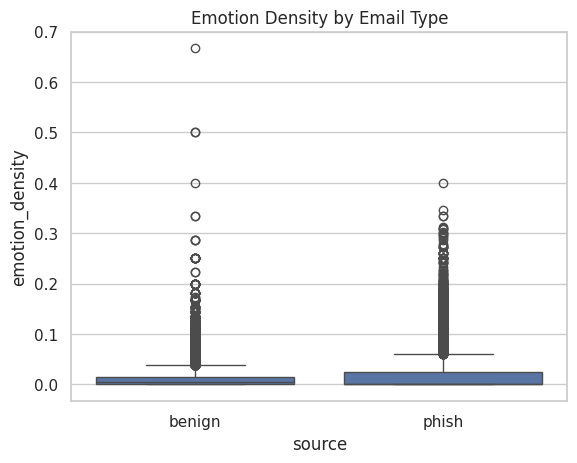

In [72]:
sns.boxplot(x='source', y='emotion_density', data=df)
plt.title("Emotion Density by Email Type")
plt.show()

### Insight:
Phishing emails often use emotionally manipulative language.

## Feature 6:character/word counts

In [73]:
import numpy as np

# Character count (includes punctuation, spacing)
df['char_count'] = df['Clean_Message'].apply(lambda x: len(str(x)) if pd.notnull(x) else 0)

df['word_count'] = df['Clean_Message'].apply(
    lambda x: len(re.findall(r'\b\w+\b', str(x))) if pd.notnull(x) else 0
)

# Log-transformed versions for visualization or ML models
df['log_char_count'] = np.log1p(df['char_count'])
df['log_word_count'] = np.log1p(df['word_count'])

# Average word length
df['avg_word_len'] = df.apply(
    lambda row: row['char_count'] / row['word_count'] if row['word_count'] > 0 else 0,
    axis=1
)


In [74]:
df[['char_count', 'word_count', 'avg_word_len']].describe()
df.groupby('source')[['char_count', 'word_count', 'avg_word_len']].mean()


,char_count,word_count,avg_word_len
source,,,
benign,1508.717330,195.687686,7.464651
phish,1039.247754,114.264582,7.952601


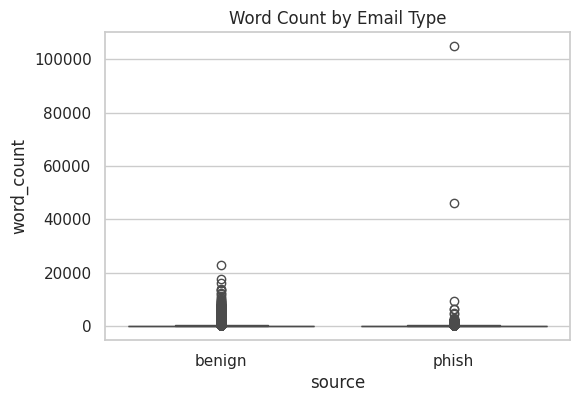

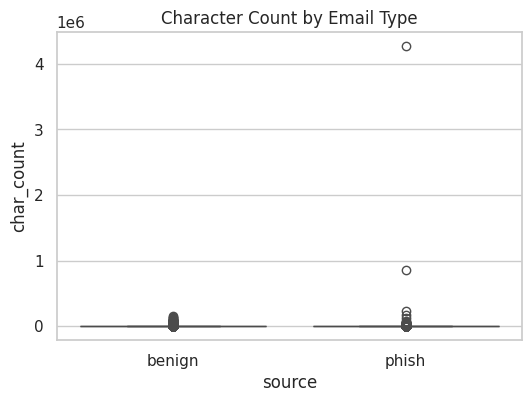

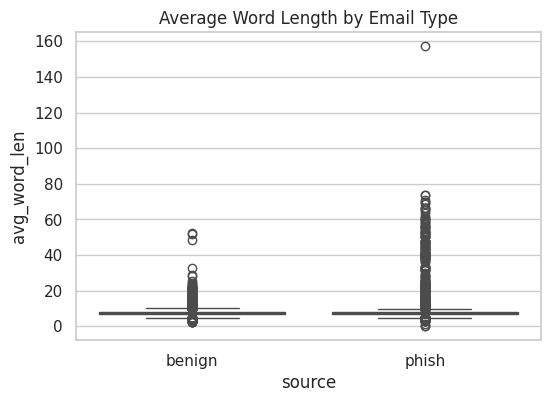

In [75]:
# Boxplot: Word count
plt.figure(figsize=(6, 4))
sns.boxplot(data=df, x='source', y='word_count')
plt.title("Word Count by Email Type")
plt.show()

# Boxplot: Character count
plt.figure(figsize=(6, 4))
sns.boxplot(data=df, x='source', y='char_count')
plt.title("Character Count by Email Type")
plt.show()

# Boxplot: Average word length
plt.figure(figsize=(6, 4))
sns.boxplot(data=df, x='source', y='avg_word_len')
plt.title("Average Word Length by Email Type")
plt.show()


## Feature 7:Capitalization Style

In [76]:
def compute_capital_ratio(text):
    if pd.isnull(text) or not isinstance(text, str) or len(text.strip()) == 0:
        return 0
    total_chars = len(text)
    capital_chars = sum(1 for c in text if c.isupper())
    return capital_chars / total_chars


In [77]:
df['capital_ratio'] = df['Message'].apply(compute_capital_ratio)
df['capital_ratio'].describe()

,capital_ratio
count,8.207800e+04
mean,7.029246e-07
std,1.579999e-04
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,0.000000e+00
max,4.444444e-02


In [78]:
df.groupby('source')['capital_ratio'].mean()

,capital_ratio
source,
benign,1.465654e-07
phish,1.212381e-06


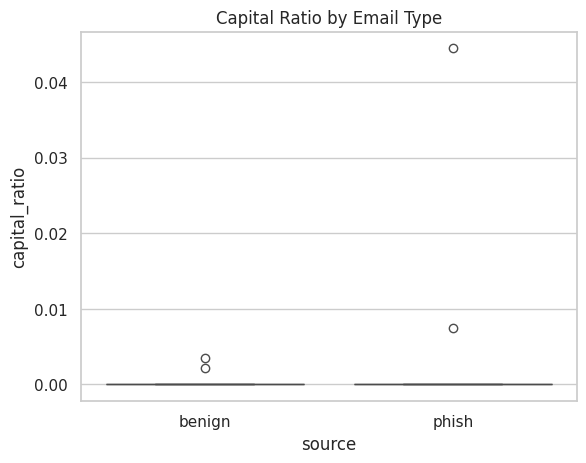

In [79]:
sns.boxplot(x='source', y='capital_ratio', data=df)
plt.title("Capital Ratio by Email Type")
plt.show()

## Insights:
Phishing emails tend to have a higher proportion of capital letters compared to benign ones, with some extreme outliers using excessive capitalization. This suggests that capitalization may be used to create a sense of urgency or intimidation. Although the overall ratios are small, the difference in mean values and outlier behavior indicates that capital_ratio is a valuable feature for distinguishing phishing emails.

## Feature Correlation Heatmap

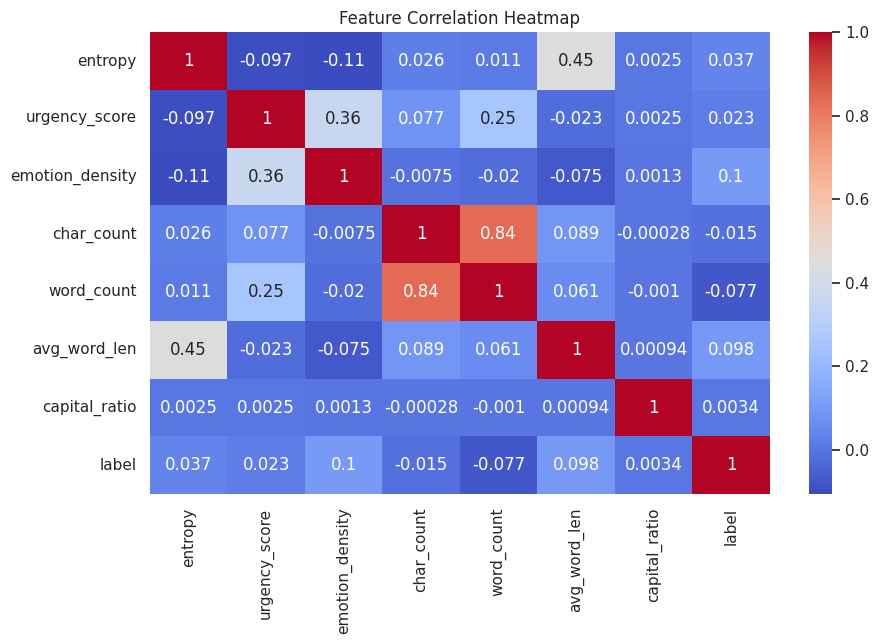

In [80]:
plt.figure(figsize=(10, 6))
sns.heatmap(df[['entropy', 'urgency_score', 'emotion_density', 'char_count', 'word_count', 'avg_word_len', 'capital_ratio', 'label']].corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

## Most Common Words(keywords)

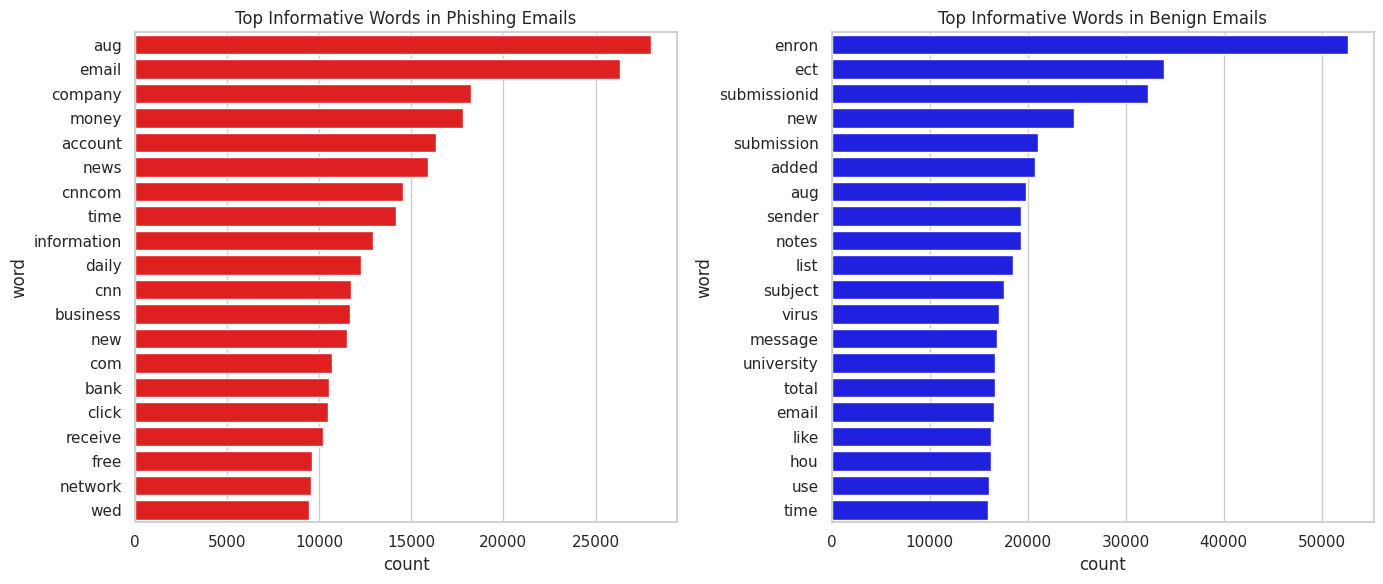

In [81]:
import string
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 1. Function to clean, tokenize, and count words
def get_top_clean_words(texts, n=20):
    stop_words = set(ENGLISH_STOP_WORDS)
    all_text = ' '.join(texts.dropna().astype(str)).lower()
    # Remove punctuation and digits
    all_text = all_text.translate(str.maketrans('', '', string.punctuation + string.digits))
    words = all_text.split()
    # Filter out stopwords and meaningless tokens
    filtered_words = [w for w in words if w not in stop_words and len(w) > 2]
    return Counter(filtered_words).most_common(n)

# 2. Extract top words per class
top_phish_clean = get_top_clean_words(df[df['label'] == 1]['Clean_Message'])
top_benign_clean = get_top_clean_words(df[df['label'] == 0]['Clean_Message'])

# 3. Convert to DataFrame for plotting
phish_df_clean = pd.DataFrame(top_phish_clean, columns=['word', 'count'])
benign_df_clean = pd.DataFrame(top_benign_clean, columns=['word', 'count'])

# 4. Plot bar charts
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.barplot(data=phish_df_clean, x='count', y='word', color='red')
plt.title("Top Informative Words in Phishing Emails")

plt.subplot(1, 2, 2)
sns.barplot(data=benign_df_clean, x='count', y='word', color='blue')
plt.title("Top Informative Words in Benign Emails")

plt.tight_layout()
plt.show()

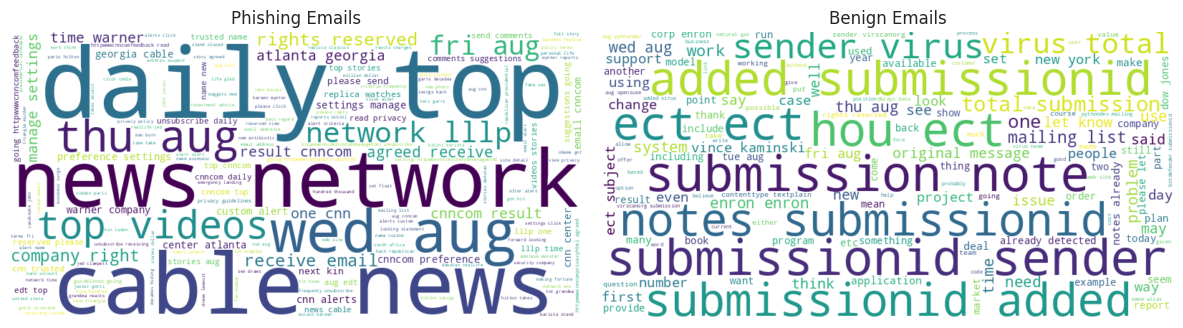

In [82]:
from wordcloud import WordCloud
# Join all words into a single string
phish_text = ' '.join(df[df['label'] == 1]['Clean_Message'].dropna().astype(str))
benign_text = ' '.join(df[df['label'] == 0]['Clean_Message'].dropna().astype(str))

# Generate word clouds
phish_wc = WordCloud(width=800, height=400, background_color='white').generate(phish_text)
benign_wc = WordCloud(width=800, height=400, background_color='white').generate(benign_text)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(phish_wc, interpolation='bilinear')
plt.axis('off')
plt.title("Phishing Emails")

plt.subplot(1, 2, 2)
plt.imshow(benign_wc, interpolation='bilinear')
plt.axis('off')
plt.title("Benign Emails")

plt.tight_layout()
plt.show()


In [84]:
# save
df.to_csv("combined_featured_dataset_new.csv", index=False)
